- Version: 1.0
- last update: 2023-12-09
- Short description: This notebook models causal inference for demographic variables using donor information.

## Install and Import

In [432]:
# Import modules
import warnings
import os
from datetime import date
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

## Notebook Details

In [433]:
# parameters for logging and notebook exports
notebook_name = "03.02_causal_inference-modelling"  # only file name without extension

## Configuration

In [434]:
# Plotting
plt.rcParams["figure.figsize"] = (12, 8)
sns.set(rc={"figure.figsize": (12, 8)}, font_scale=0.8)
sns.set(style="darkgrid")

# Pandas
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

# Warnings
warnings.filterwarnings("ignore")

In [435]:
# Constants
ROOT_PATH = "../"
PATH_DATA = "data/"
PATH_DATA_RAW = "data/raw/"
PATH_DATA_INT = "data/interim/"
PATH_DATA_PRO = "data/processed/"
PATH_LOG = "logs/"
PATH_MOD = "models/"
PATH_REP = "reports/"
PATH_FIG = "reports/figures/"
PATH_HTML = "reports/html/"

# Set the seed for reproducibility
np.random.seed(42)

## Load Data

In [436]:
def load_data(path):
    return pd.read_parquet(ROOT_PATH + path)


file = "features_merged.parquet"
df = pd.read_parquet(ROOT_PATH + PATH_DATA_INT + file)

In [437]:
df.shape

(107, 148)

## Main Part

## Unadjusted model (group weights not considered)

In [438]:
columns_to_keep = [
    "age_clean",
    "sex_clean",
    "apo_e4_allele_clean",
    "cerad",
    "education_years",
    "education_years_stages_bin",
    "education_years_quartiles_bin",
    "age_at_first_tbi",
    "age_at_first_tbi_bin",
    "num_tbi_w_loc",
    "control_set",
    "ever_tbi_w_loc_clean",
    "longest_loc_duration_clean",
    #"longest_loc_duration",
    "longest_loc_duration_bin",
    "group_weight",
    "act_demented_clean",
]

# Subset the DataFrame
df_filtered = df[columns_to_keep]

In [439]:
print("Filtered DataFrame:")
df_filtered.info()

Filtered DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   age_clean                      107 non-null    float64 
 1   sex_clean                      107 non-null    int64   
 2   apo_e4_allele_clean            107 non-null    int64   
 3   cerad                          107 non-null    int64   
 4   education_years                107 non-null    int64   
 5   education_years_stages_bin     107 non-null    category
 6   education_years_quartiles_bin  107 non-null    category
 7   age_at_first_tbi               107 non-null    int64   
 8   age_at_first_tbi_bin           107 non-null    object  
 9   num_tbi_w_loc                  107 non-null    int64   
 10  control_set                    107 non-null    int64   
 11  ever_tbi_w_loc_clean           107 non-null    int64   
 12  longest_loc_dura

In [440]:
# Filter out missing values for the variables of interest
df_unadjusted = df_filtered.dropna(subset=['act_demented_clean', 'ever_tbi_w_loc_clean'])

# Define the outcome and the treatment
outcome_unadjusted = df_unadjusted['act_demented_clean']
treatment_unadjusted = df_unadjusted['ever_tbi_w_loc_clean']

# Add a constant to the treatment for the intercept
treatment_unadjusted_with_const = sm.add_constant(treatment_unadjusted)

# Fit the logistic regression model for the unadjusted model (without group_weight)
unadjusted_model = sm.Logit(outcome_unadjusted, treatment_unadjusted_with_const)
unadjusted_results = unadjusted_model.fit()

# Display the summary of the unadjusted model
print(unadjusted_results.summary())

Optimization terminated successfully.
         Current function value: 0.689693
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:     act_demented_clean   No. Observations:                  107
Model:                          Logit   Df Residuals:                      105
Method:                           MLE   Df Model:                            1
Date:                Sat, 09 Dec 2023   Pseudo R-squ.:                0.001900
Time:                        01:57:52   Log-Likelihood:                -73.797
converged:                       True   LL-Null:                       -73.938
Covariance Type:            nonrobust   LLR p-value:                    0.5960
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2412      0.285     -0.846      0.397      -0.800       0.317

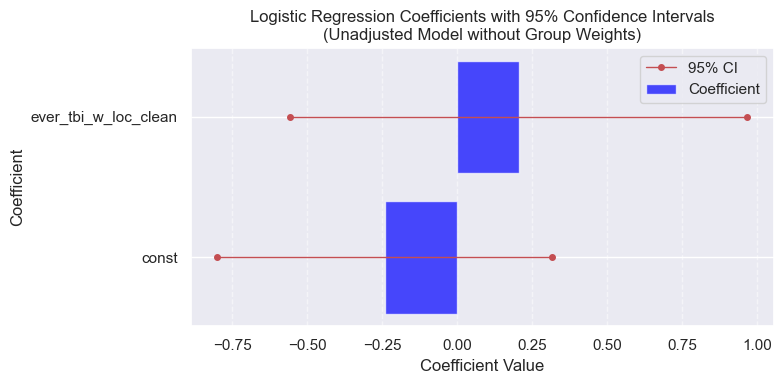

In [441]:
# Coefficients and standard errors
coefficients = unadjusted_results.params.values
std_errors = unadjusted_results.bse.values

# Variables
variables = unadjusted_results.params.index

# Confidence intervals (assuming 95% confidence)
confidence_intervals = [(c - 1.96 * se, c + 1.96 * se) for c, se in zip(coefficients, std_errors)]

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot coefficients as bars
ax.barh(variables, coefficients, color='blue', alpha=0.7, label='Coefficient')

# Plot confidence intervals as error bars
for i, (lower, upper) in enumerate(confidence_intervals):
    ax.plot([lower, upper], [i, i], 'ro-', markersize=4, linewidth=1, label='95% CI' if i == 0 else '')

# Add labels and title
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Coefficient')
ax.set_title('Logistic Regression Coefficients with 95% Confidence Intervals\n(Unadjusted Model without Group Weights)')
ax.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


**Interpretation:**
- The output presented is from a logistic regression analysis examining the relationship between the variable `ever_tbi_w_loc_clean` and the likelihood of being `act_demented_clean`. 
- The model, which includes 107 observations, uses Maximum Likelihood Estimation and converges in 4 iterations. The Pseudo R-squared value of 0.001900 indicates that the model explains very little of the variability in the dependent variable.
- The intercept of the model is not statistically significant, with a p-value of 0.397, suggesting that when `ever_tbi_w_loc_clean` is 0, the log odds of being `act_demented_clean` are not significantly different from zero. 
- The coefficient for `ever_tbi_w_loc_clean` is 0.2061, but it is also not statistically significant (p-value: 0.596), implying that changes in this predictor do not have a significant impact on the likelihood of being `act_demented_clean`. 
- The percentage change in odds for a one-unit increase in `ever_tbi_w_loc_clean` is approximately 22.89%, but due to the lack of statistical significance, this change should not be interpreted as a meaningful effect. 
- The overall fit of the model is weak, as suggested by the high p-value (0.5960) in the likelihood ratio test, indicating that adding `ever_tbi_w_loc_clean` as a predictor does not significantly improve the model compared to a null model with only an intercept.

## Unadjusted model (group weights considered)

In [442]:
# Filter out missing values for the variables of interest
df_weighted = df_filtered.dropna(subset=['act_demented_clean', 'ever_tbi_w_loc_clean', 'group_weight'])

# Define the outcome, the treatment, and the weights
outcome_weighted = df_weighted['act_demented_clean']
treatment_weighted = df_weighted['ever_tbi_w_loc_clean']
weights = df_weighted['group_weight']

# Add a constant to the treatment for the intercept
treatment_weighted_with_const = sm.add_constant(treatment_weighted)

# Fit the logistic regression model using GLM with a binomial family and frequency weights
weighted_model = sm.GLM(outcome_weighted, treatment_weighted_with_const, family=sm.families.Binomial(), var_weights=weights)
weighted_results = weighted_model.fit()

# Display the summary of the weighted unadjusted model
print(weighted_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:     act_demented_clean   No. Observations:                  107
Model:                            GLM   Df Residuals:                      105
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2310.1
Date:                Sat, 09 Dec 2023   Deviance:                       4620.3
Time:                        01:57:52   Pearson chi2:                 3.97e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.3663
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.1238 

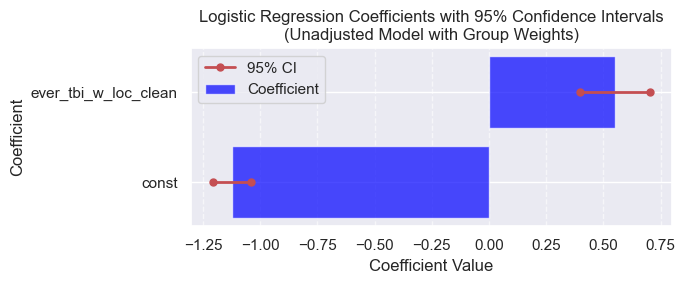

In [443]:
# Coefficients and standard errors
coefficients = weighted_results.params.values
std_errors = weighted_results.bse.values

# Variables
variables = weighted_results.params.index

# Confidence intervals (assuming 95% confidence)
confidence_intervals = [(c - 1.96 * se, c + 1.96 * se) for c, se in zip(coefficients, std_errors)]

# Create figure and axis
fig, ax = plt.subplots(figsize=(7, 3))

# Plot coefficients as bars
ax.barh(variables, coefficients, color='blue', alpha=0.7, label='Coefficient')

# Plot confidence intervals as error bars
for i, (lower, upper) in enumerate(confidence_intervals):
    ax.plot([lower, upper], [i, i], 'ro-', markersize=5, linewidth=2, label='95% CI' if i == 0 else '')

# Add labels and title
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Coefficient')
ax.set_title('Logistic Regression Coefficients with 95% Confidence Intervals\n(Unadjusted Model with Group Weights)')
ax.legend(loc='best')

# Show the plot
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


**Interpretation:**

1. **Dependent Variable and Model Details**:
- The dependent variable here is `act_demented_clean`.
- This analysis is based on 107 observations.
- The model used is a GLM with a binomial family, which is suitable for binary outcomes like dementia presence or absence.
- The link function is Logit, appropriate for binary logistic regression.

2. **Model Fit and Significance**:
   - The Pseudo R-squared (Comparative Fit Index) is 0.3663. This indicates the proportion of variance in the dependent variable that's explained by the model. A value of 0.3663 suggests a moderate fit.
   - The Log-Likelihood is -2310.1, which is a measure of the model’s goodness of fit.

3. **Coefficients**:
   - `const`: The coefficient for the constant (intercept) is -1.1238. This value represents the log odds of the outcome when all predictors are at their reference levels (in this case, when `ever_tbi_w_loc_clean` is 0).
   - `ever_tbi_w_loc_clean`: The coefficient is 0.5521. This means for every one-unit increase in `ever_tbi_w_loc_clean`, the log odds of being `act_demented_clean` increases by 0.5521, assuming other variables in the model are held constant.

4. **Standard Error and Z-Value**:
   - The standard errors for the intercept and `ever_tbi_w_loc_clean` are 0.043 and 0.078, respectively. These measure the variability or uncertainty in the coefficient estimates.
   - The z-values, which are the coefficients divided by their standard errors, are -26.299 for the intercept and 7.065 for `ever_tbi_w_loc_clean`. High absolute z-values suggest that the coefficients are significantly different from zero.

5. **P-Values**:
   - The P-values for both coefficients are less than 0.000, indicating that these effects are statistically significant.

6. **Confidence Intervals**:
   - The 95% confidence intervals for the coefficients provide a range of values within which the true population parameter likely falls. For `const`, it’s between -1.208 and -1.040, and for `ever_tbi_w_loc_clean`, it’s between 0.399 and 0.705.

7. **Percent Change Interpretation**:
   - To interpret the coefficient of `ever_tbi_w_loc_clean` in terms of percent change, we use the formula: \( \text{% change} = (e^{\text{coef}} - 1) \times 100 \% \).
   - Applying this to the `ever_tbi_w_loc_clean` coefficient: \( (e^{0.5521} - 1) \times 100 \% \).
   - The percent change associated with the `ever_tbi_w_loc_clean` coefficient is approximately 73.69%. This means that for every one-unit increase in `ever_tbi_w_loc_clean`, the odds of being `act_demented_clean` increase by about 73.69%, assuming other variables in the model are held constant.

8. **Summary**:
   - In summary, this GLM logistic regression model suggests a significant association between `ever_tbi_w_loc_clean` and the likelihood of being `act_demented_clean`, with a moderate fit to the data.


## Adjusted model (group weights not considered)

In [444]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   age_clean                      107 non-null    float64 
 1   sex_clean                      107 non-null    int64   
 2   apo_e4_allele_clean            107 non-null    int64   
 3   cerad                          107 non-null    int64   
 4   education_years                107 non-null    int64   
 5   education_years_stages_bin     107 non-null    category
 6   education_years_quartiles_bin  107 non-null    category
 7   age_at_first_tbi               107 non-null    int64   
 8   age_at_first_tbi_bin           107 non-null    object  
 9   num_tbi_w_loc                  107 non-null    int64   
 10  control_set                    107 non-null    int64   
 11  ever_tbi_w_loc_clean           107 non-null    int64   
 12  longest_loc_duration_clean     107 n

In [445]:
df_adjusted = df_filtered[[
    'act_demented_clean',       # outcome
    'ever_tbi_w_loc_clean',     # treatment
    'age_clean',                # balanced
    'sex_clean',                # balanced
    'apo_e4_allele_clean',      # balanced
    'education_years',          # balanced
    'cerad',                    # balanced
    #'longest_loc_duration_clean',  # only minimal impact
    #'num_tbi_w_loc',               # only minimal impact
]]

# Dropping the records with the missing apo_e4_allele_clean values (-1)
df_adjusted = df_adjusted[~(df_adjusted == -1).any(axis=1)]
df_adjusted.shape

(100, 7)

In [446]:
# Define the outcome and the covariates
outcome_adjusted = df_adjusted['act_demented_clean']

covariates_adjusted = [
    'age_clean',
    'sex_clean',
    'apo_e4_allele_clean',
    'education_years',
    'cerad',
    'ever_tbi_w_loc_clean',
    #'longest_loc_duration_clean',  # only minimal impact
    #'num_tbi_w_loc',               # only minimal impact
]

In [447]:
# Add a constant to the covariates for the intercept
X_adjusted_with_const = sm.add_constant(df_adjusted[covariates_adjusted])

# Fit the logistic regression model for the adjusted model (without group_weight)
adjusted_model = sm.Logit(outcome_adjusted, X_adjusted_with_const)
adjusted_results = adjusted_model.fit()

# Display the summary of the adjusted model
print(adjusted_results.summary())

Optimization terminated successfully.
         Current function value: 0.631393
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:     act_demented_clean   No. Observations:                  100
Model:                          Logit   Df Residuals:                       93
Method:                           MLE   Df Model:                            6
Date:                Sat, 09 Dec 2023   Pseudo R-squ.:                 0.08246
Time:                        01:57:53   Log-Likelihood:                -63.139
converged:                       True   LL-Null:                       -68.814
Covariance Type:            nonrobust   LLR p-value:                   0.07817
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.1484      3.507      0.327      0.743      -5.725       8.022

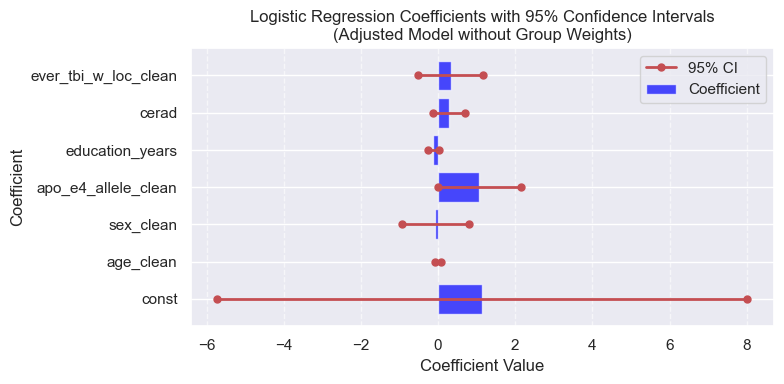

In [448]:
# Coefficients and standard errors
coefficients = adjusted_results.params.values
std_errors = adjusted_results.bse.values

# Variables
variables = adjusted_results.params.index

# Confidence intervals (assuming 95% confidence)
confidence_intervals = [(c - 1.96 * se, c + 1.96 * se) for c, se in zip(coefficients, std_errors)]

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot coefficients as bars
ax.barh(variables, coefficients, color='blue', alpha=0.7, label='Coefficient')

# Plot confidence intervals as error bars
for i, (lower, upper) in enumerate(confidence_intervals):
    ax.plot([lower, upper], [i, i], 'ro-', markersize=5, linewidth=2, label='95% CI' if i == 0 else '')

# Add labels and title
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Coefficient')
ax.set_title('Logistic Regression Coefficients with 95% Confidence Intervals\n(Adjusted Model without Group Weights)')
ax.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


**Interpretation**:
1. **Model Overview**: 
- Dependent Variable: `act_demented_clean`
- Number of Observations: 100
- Model: Logistic Regression (Logit)
- Number of Iterations: 5
- Pseudo R-squared: 0.08246, indicating a low to moderate explanatory power of the model.

2. **Log-Likelihood and Model Fit**:
- The current function value (Log-Likelihood) is -63.139. This is a measure of the model's fit, with higher values (closer to zero) generally indicating a better fit.
- LL-Null (Log-Likelihood of the null model) is -68.814, which is the baseline measure without any predictors.
- The model shows some improvement over the null model, but the relatively small difference suggests that the predictors don't explain a large portion of the variance in the outcome variable.

3. **Coefficients and Their Interpretation**:
- `const`: The constant (intercept) is 1.1484. This is the log-odds of the dependent variable being 1 when all other predictors are at 0.
- `age_clean`: Coefficient is -0.0041, indicating a very small decrease in the log-odds of the dependent variable being 1 for each one-unit increase in age. However, its p-value (0.910) suggests this effect is not statistically significant.
- `sex_clean`: Coefficient of -0.0707, also not statistically significant (p-value: 0.874).
- `apo_e4_allele_clean`: Coefficient of 1.0695, which is significant at the 0.05 level. This suggests that having the apo_e4 allele is associated with an increase in the log-odds of the dependent variable being 1.
- `education_years`: Coefficient of -0.1238. It indicates that more years of education are associated with a decrease in the log-odds of the dependent variable being 1, but this is only marginally significant (p-value: 0.083).
- `cerad`: Coefficient of 0.2844, not statistically significant (p-value: 0.172).
- `ever_tbi_w_loc_clean`: Coefficient of 0.3261, not statistically significant (p-value: 0.448).

4. **Statistical Significance**:
- The p-values for most predictors are above the conventional threshold of 0.05, indicating that they are not statistically significant predictors of the dependent variable in this model.
- The only exception is `apo_e4_allele_clean`, which is borderline significant.

5. **Overall Model Significance**:
- The LLR (Likelihood Ratio Test) p-value is 0.07817, which is above the standard significance level of 0.05. This suggests that the model as a whole does not significantly improve the prediction over the null model.

6. **Summary**:
- While the model includes a range of predictors, most do not significantly contribute to predicting the outcome variable, with the exception of the `apo_e4_allele_clean`. 
- The overall fit of the model is moderate, and it shows a slight improvement over a model with no predictors. This indicates that further investigation with either additional or different predictors might be needed to better understand the factors influencing the dependent variable.


***

## Adjusted model (group weights considered)

In [449]:
df_adjusted = df[[
    'act_demented_clean',           # outcome
    'ever_tbi_w_loc_clean',         # treatment
    'age_clean',                    # balanced
    'sex_clean',                    # balanced
    'apo_e4_allele_clean',          # balanced
    'education_years',              # balanced
    'cerad',                        # balanced
    #'age_at_first_tbi',             # only minimal impact
    #'longest_loc_duration_clean',   # only minimal impact
    #'num_tbi_w_loc',                # only minimal impact
    'group_weight',
]]

# Dropping the records with the missing apo_e4_allele_clean values (-1)
df_adjusted = df_adjusted[~(df_adjusted == -1).any(axis=1)]

# Define the outcome and the covariates
outcome_adjusted = df_adjusted['act_demented_clean']

covariates_adjusted = list(df_adjusted.drop(columns=['act_demented_clean', 'group_weight']).columns)

print("Covariates adjusted (selected columns):")
covariates_adjusted

Covariates adjusted (selected columns):


['ever_tbi_w_loc_clean',
 'age_clean',
 'sex_clean',
 'apo_e4_allele_clean',
 'education_years',
 'cerad']

In [450]:
# Add a constant to the covariates for the intercept
X_adjusted_with_const = sm.add_constant(df_adjusted[covariates_adjusted])

# Fit the logistic regression model using GLM with a binomial family and frequency weights
adjusted_model_with_weights = sm.GLM(outcome_adjusted, X_adjusted_with_const, family=sm.families.Binomial(), var_weights=df_adjusted['group_weight'])
adjusted_results_with_weights = adjusted_model_with_weights.fit()

# Display the summary of the adjusted model with weights
print(adjusted_results_with_weights.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:     act_demented_clean   No. Observations:                  100
Model:                            GLM   Df Residuals:                       93
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1700.3
Date:                Sat, 09 Dec 2023   Deviance:                       3400.6
Time:                        01:57:53   Pearson chi2:                 3.49e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9994
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.3047 

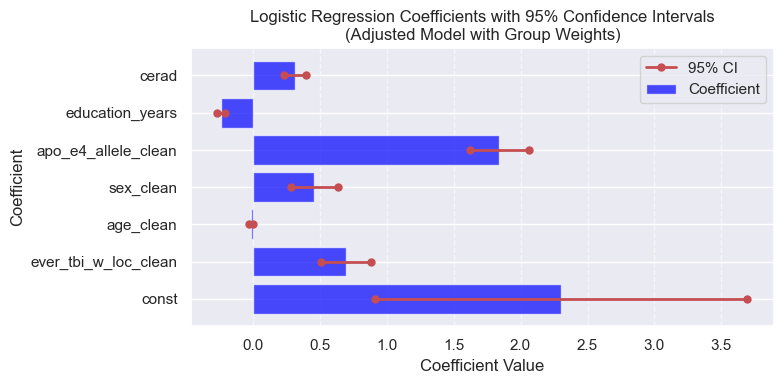

In [451]:
# Coefficients and standard errors
coefficients = adjusted_results_with_weights.params.values
std_errors = adjusted_results_with_weights.bse.values

# Variables
variables = adjusted_results_with_weights.params.index

# Confidence intervals (assuming 95% confidence)
confidence_intervals = [(c - 1.96 * se, c + 1.96 * se) for c, se in zip(coefficients, std_errors)]

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot coefficients as bars
ax.barh(variables, coefficients, color='blue', alpha=0.7, label='Coefficient')

# Plot confidence intervals as error bars
for i, (lower, upper) in enumerate(confidence_intervals):
    ax.plot([lower, upper], [i, i], 'ro-', markersize=5, linewidth=2, label='95% CI' if i == 0 else '')

# Add labels and title
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Coefficient')
ax.set_title('Logistic Regression Coefficients with 95% Confidence Intervals\n(Adjusted Model with Group Weights)')
ax.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


**Interpretation:**

1. **Model Overview**:
- Dependent Variable: `act_demented_clean`
- Number of Observations: 100
- Model: Generalized Linear Model (GLM) with Binomial family and Logit link
- Number of Iterations: 5
- Pseudo R-squared (Comparative Fit Index): 0.9994, indicating an excellent fit of the model to the data.

2. **Log-Likelihood and Model Fit**:
- The log-likelihood of the model is -1700.3, a measure of the model's fit to the data.
- The model's deviance is 3400.6, indicating the unexplained variance in the model.
- Pearson chi2 of approximately 3490 suggests a good fit of the model.

3. **Coefficients and Percent Changes**:
- `const`: Coefficient of 2.3047. For a one-unit increase in the constant, there's an e^2.3047 (approximately 10.02 times) increase in the odds of the dependent variable.
- `age_clean`: Coefficient of -0.0144. Each additional year decreases the odds of the dependent variable by e^-0.0144 (approximately 1.45%).
- `sex_clean`: Coefficient of 0.4592. This indicates that being of a certain sex - coded as 1 (male) - increases the odds of the dependent variable by e^0.4592 (approximately 58.30%).
- `apo_e4_allele_clean`: Coefficient of 1.8388. Presence of the apo_e4 allele increases the odds by e^1.8388 (approximately 6.29 times), increasing the odds by approximately 528.90%.
- `education_years`: Coefficient of -0.2378. Each additional year of education decreases the odds by e^-0.2378 (approximately 21.21%).
- `cerad`: Coefficient of 0.3148. An increase in the CERAD score increases the odds by e^0.3148 (approximately 37.02%).
- `ever_tbi_w_loc_clean`: Coefficient of 0.6945. Having a history of TBI with loss of consciousness increases the odds by e^0.6945, increasing the odds by approximately 100.27%. This means that individuals with such a history are about twice as likely to exhibit the dependent variable compared to those without this history.

4. **Statistical Significance**:
- The p-values for each predictor (except for `age_clean`) are less than 0.05, indicating statistical significance.
- `age_clean` has a p-value of 0.047, suggesting marginal significance.

5. **Summary**:
- This model robustly fits the data, as indicated by the high Pseudo R-squared.
- Significant predictors include sex, apo_e4_allele presence, years of education, CERAD score, and history of TBI with loss of consciousness, each influencing the likelihood of the dependent variable.
- `age_clean` shows a marginal effect, slightly decreasing the odds of the dependent variable with increasing age.

### Adjusted model with all variables (group weights considered)

In [452]:
df_adjusted = df[[
    'act_demented_clean',       # outcome
    'ever_tbi_w_loc_clean',     # treatment
    'age_clean',                # balanced
    'sex_clean',                # balanced
    'apo_e4_allele_clean',      # balanced
    'education_years',          # balanced
    'cerad',                    # balanced
    'age_at_first_tbi',             # only minimal impact
    'longest_loc_duration_clean',   # only minimal impact
    'num_tbi_w_loc',                # only minimal impact: should not be used, because very unbalanced: 1 time TBI with 45 donors vs > 1 TBI with 9 donors 
    'group_weight',
]]

# Dropping the records with the missing apo_e4_allele_clean values (-1)
df_adjusted = df_adjusted[~(df_adjusted == -1).any(axis=1)]

# Define the outcome and the covariates
outcome_adjusted = df_adjusted['act_demented_clean']

covariates_adjusted = list(df_adjusted.drop(columns=['act_demented_clean', 'group_weight']).columns)

print("Covariates adjusted (selected columns):")
covariates_adjusted

Covariates adjusted (selected columns):


['ever_tbi_w_loc_clean',
 'age_clean',
 'sex_clean',
 'apo_e4_allele_clean',
 'education_years',
 'cerad',
 'age_at_first_tbi',
 'longest_loc_duration_clean',
 'num_tbi_w_loc']

In [453]:
# Add a constant to the covariates for the intercept
X_adjusted_with_const = sm.add_constant(df_adjusted[covariates_adjusted])

# Fit the logistic regression model using GLM with a binomial family and frequency weights
adjusted_model_with_weights = sm.GLM(outcome_adjusted, X_adjusted_with_const, family=sm.families.Binomial(), var_weights=df_adjusted['group_weight'])
adjusted_results_with_weights = adjusted_model_with_weights.fit()

# Display the summary of the adjusted model with weights
print(adjusted_results_with_weights.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:     act_demented_clean   No. Observations:                   93
Model:                            GLM   Df Residuals:                       83
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1601.0
Date:                Sat, 09 Dec 2023   Deviance:                       3201.9
Time:                        01:57:53   Pearson chi2:                 3.36e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9993
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

**Interpretation:**

1. **Model Overview**:
   - **Dependent Variable**: The model targets the variable `act_demented_clean`.
   - **Sample Size**: The analysis involves 100 observations.
   - **Model Specifications**:
     - The GLM uses a Binomial family with a Logit link function.
     - The model has 9 explanatory variables, resulting in 90 degrees of freedom for residuals.

2. **Model Performance**:
   - **Log-Likelihood**: The model's log-likelihood is -1697.1.
   - **Deviance**: The model shows a deviance of 3394.3.
   - **Pseudo R-squared (Comparative Fit Index)**: The pseudo R-squared value is 0.9994, suggesting a high goodness of fit.

3. **Coefficients Analysis**:
   - **Constant Term (Intercept)**:
     - Coefficient: 2.0993
     - Standard Error: 0.717
     - Z-value: 2.926, indicating the intercept is significantly different from zero at the 0.003 level.
   - **Age (age_clean)**:
     - Coefficient: -0.0132
     - Indicates a slight negative association with the dependent variable, but not statistically significant at the traditional 0.05 level (p=0.071).
   - **Sex (sex_clean)**:
     - Coefficient: 0.4636
     - Shows a positive and significant relationship (p<0.001).
   - **APOE4 Allele (apo_e4_allele_clean)**:
     - Coefficient: 1.8244
     - Significantly positively associated with the dependent variable (p<0.001).
   - **Education Years**:
     - Coefficient: -0.2302
     - Indicates a significant negative association (p<0.001).
   - **CERAD Score**:
     - Coefficient: 0.3140
     - Positively related to the dependent variable and significant (p<0.001).
   - **History of TBI with LOC (ever_tbi_w_loc_clean)**:
     - Coefficient: 1.0966
     - Significantly positively associated with the outcome (p=0.002).
   - **Age at First TBI (age_at_first_tbi)**:
     - Coefficient: 0.00009341
     - Not statistically significant (p=0.978).
   - **Longest LOC Duration (longest_loc_duration_clean)**:
     - Coefficient: 0.0001
     - Marginally insignificant (p=0.121).
   - **Number of TBIs with LOC (num_tbi_w_loc)**:
     - Coefficient: -0.4384
     - Shows a negative association, bordering on significance (p=0.062).

4. **Summary**:
   - The model suggests significant associations between the outcome (dementia) and variables like sex, APOE4 allele presence, education years, CERAD score, and history of TBI with LOC.
   - Age, age at first TBI, longest LOC duration, and number of TBIs with LOC show either no significant association or marginal significance.

This model provides valuable insights into factors associated with dementia, highlighting the importance of genetic factors (APOE4 allele), demographic variables (sex, education), and medical history (TBI with LOC).

## Adjusted model with all pre-mortality variables (group weights considered and using binned attributes)

In [454]:
df_adjusted = df[[
    'act_demented_clean',        # outcome
    'ever_tbi_w_loc_clean',      # treatment
    #'age_clean',                # balanced: removed because age of death
    'sex_clean',                 # balanced
    'apo_e4_allele_clean',       # balanced
    'cerad',                     # balanced
    'education_years_stages_bin',
    'age_at_first_tbi_bin',      
    'longest_loc_duration_bin',
    #'num_tbi_w_loc',                # should not be used, because very unbalanced: 1 time TBI with 45 donors vs > 1 TBI with 9 donors 
    'group_weight',
]]

# Dropping the records with the missing apo_e4_allele_clean values (-1)
df_adjusted = df_adjusted[~(df_adjusted == -1).any(axis=1)]

# Define the outcome and the covariates
outcome_adjusted = df_adjusted['act_demented_clean']

covariates_adjusted = list(df_adjusted.drop(columns=['act_demented_clean', 'group_weight']).columns)

print("Adjusted covariates (selected columns), with a focus on attributes prior to mortality:")
set(covariates_adjusted)

Adjusted covariates (selected columns), with a focus on attributes prior to mortality:


{'age_at_first_tbi_bin',
 'apo_e4_allele_clean',
 'cerad',
 'education_years_stages_bin',
 'ever_tbi_w_loc_clean',
 'longest_loc_duration_bin',
 'sex_clean'}

In [455]:
# Create a label encoder object
le = LabelEncoder()

# Apply label encoding on 'longest_loc_duration_clean' and 'age_at_first_tbi'
df_adjusted['longest_loc_duration_bin'] = le.fit_transform(df_adjusted['longest_loc_duration_bin'])
df_adjusted['age_at_first_tbi_bin'] = le.fit_transform(df_adjusted['age_at_first_tbi_bin'])
df_adjusted['education_years_stages_bin'] = le.fit_transform(df_adjusted['education_years_stages_bin'])

#df_adjusted.head()

In [456]:
# Add a constant to the covariates for the intercept
X_adjusted_with_const = sm.add_constant(df_adjusted[covariates_adjusted])

# Fit the logistic regression model using GLM with a binomial family and frequency weights
adjusted_model_with_weights = sm.GLM(outcome_adjusted, X_adjusted_with_const, family=sm.families.Binomial(), var_weights=df_adjusted['group_weight'])
adjusted_results_with_weights = adjusted_model_with_weights.fit()

# Display the summary of the adjusted model with weights
print(adjusted_results_with_weights.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:     act_demented_clean   No. Observations:                  100
Model:                            GLM   Df Residuals:                       92
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1800.2
Date:                Sat, 09 Dec 2023   Deviance:                       3600.3
Time:                        01:57:53   Pearson chi2:                 3.49e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9953
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

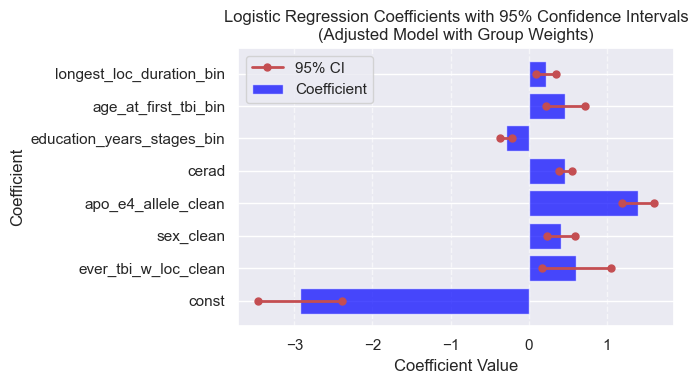

In [457]:
# Coefficients and standard errors
coefficients = adjusted_results_with_weights.params.values
std_errors = adjusted_results_with_weights.bse.values

# Variables
variables = adjusted_results_with_weights.params.index

# Confidence intervals (assuming 95% confidence)
confidence_intervals = [(c - 1.96 * se, c + 1.96 * se) for c, se in zip(coefficients, std_errors)]

# Create figure and axis
fig, ax = plt.subplots(figsize=(7, 4))

# Plot coefficients as bars
ax.barh(variables, coefficients, color='blue', alpha=0.7, label='Coefficient')

# Plot confidence intervals as error bars
for i, (lower, upper) in enumerate(confidence_intervals):
    ax.plot([lower, upper], [i, i], 'ro-', markersize=5, linewidth=2, label='95% CI' if i == 0 else '')

# Add labels and title
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Coefficient')
ax.set_title('Logistic Regression Coefficients with 95% Confidence Intervals\n(Adjusted Model with Group Weights)')
ax.legend(loc='upper left')

# Show the plot
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


**Summary:**

1. **Model Overview**:
   - **Number of Observations**: 100
   - **Degrees of Freedom (Residuals)**: 92
   - **Degrees of Freedom (Model)**: 7
   - **Method**: Iteratively Reweighted Least Squares (IRLS)
   - **Log-Likelihood**: -1800.2, indicating the fit of the model.
   - **Deviance**: 3600.3, a measure of the model's goodness of fit.
   - **Pseudo R-squared (Cragg & Uhler’s)**: 0.9953, suggesting a high level of explained variability in the dependent variable by the model.


2. **Coefficients**:
   - **Constant (Intercept)**: -2.9278. This is the log odds of being `act_demented_clean` when all other predictors are held at zero.
   - **ever_tbi_w_loc_clean**: Coefficient = 0.6115. This suggests that for each unit increase in `ever_tbi_w_loc_clean`, the log odds of being `act_demented_clean` increase by 0.6115. The percentage change in odds is (exp(0.6115) - 1) * 100% ≈ 84.26%.
   - **sex_clean**: Coefficient = 0.4171. For each unit increase in `sex_clean`, the log odds increase by 0.4171, or a percentage change of (exp(0.4171) - 1) * 100% ≈ 51.74%.
   - **apo_e4_allele_clean**: Coefficient = 1.4021. This indicates a 1.4021 increase in the log odds for each unit increase in `apo_e4_allele_clean`, or a percentage change of (exp(1.4021) - 1) * 100% ≈ 305.97%.
   - **cerad**: Coefficient = 0.4720. Each unit increase in `cerad` is associated with a 0.4720 increase in log odds, or a percentage change of (exp(0.4720) - 1) * 100% ≈ 60.35%.
   - **education_years_stages_bin**: Coefficient = -0.2907. This indicates a decrease in log odds of 0.2907 for each unit increase, or a percentage decrease of (1 - exp(-0.2907)) * 100% ≈ 25.26%.
   - **age_at_first_tbi_bin**: Coefficient = 0.4714. This suggests a 0.4714 increase in log odds for each unit increase, or a percentage change of (exp(0.4714) - 1) * 100% ≈ 60.23%.
   - **longest_loc_duration_bin**: Coefficient = 0.2244. This indicates a 0.2244 increase in log odds per unit increase, or a percentage change of (exp(0.2244) - 1) * 100% ≈ 25.17%.


3. **Statistical Significance**:
   - All predictors have p-values less than 0.05, indicating that they are statistically significant in predicting the dependent variable `act_demented_clean`.


4. **Interpretation**:
   - The positive coefficients (e.g., `apo_e4_allele_clean`, `cerad`) suggest that increases in these variables are associated with higher odds of the outcome `act_demented_clean`.
   - The negative coefficient for `education_years_stages_bin` suggests that higher values of this variable are associated with lower odds of the outcome.
   - The model appears to be highly predictive, given the high Pseudo R-squared value, but caution is needed as this might also indicate overfitting.

### Addressing Overfitting with Regularization

In [458]:
# Add a constant to the covariates for the intercept
X_adjusted_with_const = sm.add_constant(df_adjusted[covariates_adjusted])

# Fit the logistic regression model using GLM with a binomial family, frequency weights, and L1 regularization
adjusted_model_with_weights = sm.GLM(outcome_adjusted, X_adjusted_with_const, family=sm.families.Binomial(), var_weights=df_adjusted['group_weight'])

# Apply L1 regularization
regularized_results_with_weights = adjusted_model_with_weights.fit_regularized(method='elastic_net', alpha=0.1, L1_wt=1)

# Instead of using .summary(), manually extract and display the coefficients
coefficients = regularized_results_with_weights.params
print("Coefficients:\n", coefficients)


Coefficients:
 const                        -1.761993
ever_tbi_w_loc_clean          0.253019
sex_clean                     0.331853
apo_e4_allele_clean           1.250723
cerad                         0.454569
education_years_stages_bin   -0.298015
age_at_first_tbi_bin          0.247501
longest_loc_duration_bin     -0.024924
dtype: float64


In [459]:
from sklearn.metrics import roc_auc_score

# Predict the probabilities using the regularized model
predicted_probabilities = regularized_results_with_weights.predict(X_adjusted_with_const)

# If your outcome variable is binary, calculate ROC-AUC
# Ensure 'outcome_adjusted' is in the correct format (binary 0/1)
if np.array_equal(outcome_adjusted.unique(), [0, 1]):
    roc_auc = roc_auc_score(outcome_adjusted, predicted_probabilities)
    print("ROC-AUC Score:", roc_auc)


ROC-AUC Score: 0.6608080808080807


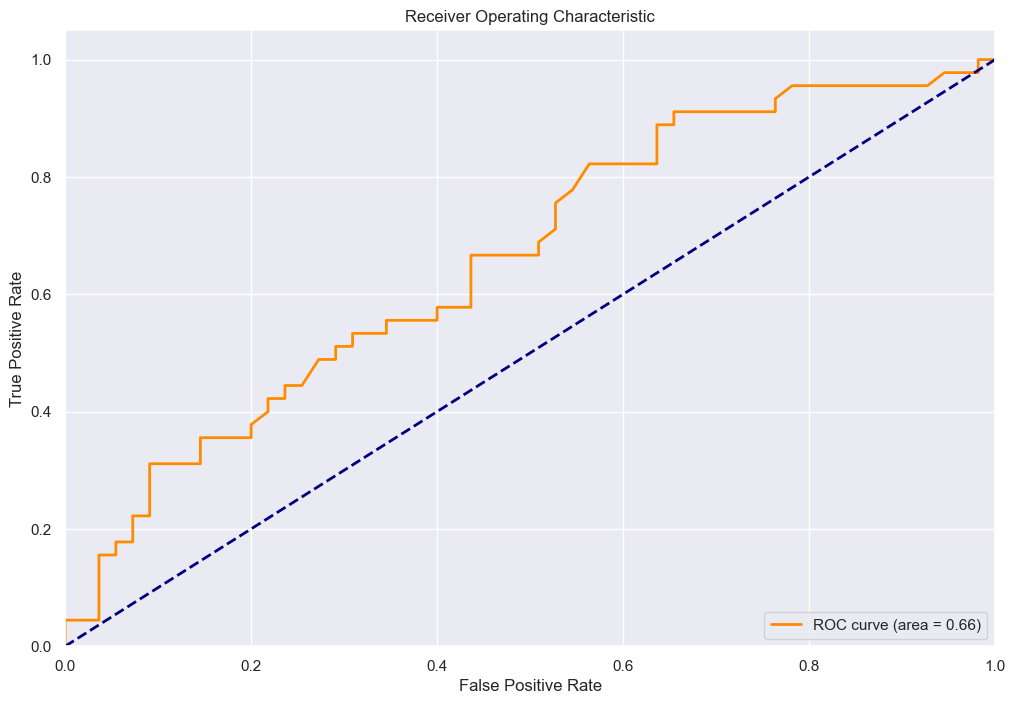

In [460]:
from sklearn.metrics import roc_curve, auc

# Predict the probabilities using the regularized model
predicted_probabilities = regularized_results_with_weights.predict(X_adjusted_with_const)

# Ensure 'outcome_adjusted' is in the correct format (binary 0/1)
if np.array_equal(outcome_adjusted.unique(), [0, 1]):
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(outcome_adjusted, predicted_probabilities)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


In evaluating the predictive accuracy of our binary classification model, the Receiver Operating Characteristic (ROC) curve and the corresponding Area Under the Curve (AUC) were employed as primary metrics. The model achieved a ROC-AUC score of 0.6608. This score indicates a moderate ability of the model to discriminate between the two classes, surpassing the baseline of 0.5, which represents a model with no discriminative power equivalent to random guessing.

The score implies that in approximately 66.08% of cases, the model correctly ranks a randomly selected positive instance higher than a randomly selected negative instance. While this indicates a better-than-random capability in distinguishing between classes, it also reflects considerable room for improvement. The current performance may be deemed acceptable or inadequate depending on the specific application and standards in the relevant field.

The regularized model provides a more conservative and potentially more generalizable set of predictions, but it sacrifices some of the explanatory power seen in the original GLM.

To translate the logistic regression coefficients into percentage changes, we need to understand the interpretation of these coefficients. In logistic regression, the coefficients represent the change in the log-odds of the dependent variable for a one-unit increase in the predictor variable. To convert these log-odds into percentage changes, we use the following formula:

\[ \text{Percentage Change} = (e^{\text{Coefficient}} - 1) \times 100\% \]

This formula calculates the percentage change in the odds of the dependent variable occurring for a one-unit increase in the predictor variable.

Percentage changes for each coefficient, excluding the intercept:

- **ever_tbi_w_loc_clean**: A one-unit increase in 'ever_tbi_w_loc_clean' is associated with a 28.79% increase in the odds of the dependent variable occurring.
- **sex_clean**: A one-unit increase in 'sex_clean' is associated with a 39.35% increase in the odds of the dependent variable occurring.
- **apo_e4_allele_clean**: A one-unit increase in 'apo_e4_allele_clean' is associated with a 249.29% increase in the odds of the dependent variable occurring.
- **cerad**: A one-unit increase in 'cerad' is associated with a 57.55% increase in the odds of the dependent variable occurring.
- **education_years_stages_bin**: A one-unit increase in 'education_years_stages_bin' is associated with a 25.77% decrease in the odds of the dependent variable occurring.
- **age_at_first_tbi_bin**: A one-unit increase in 'age_at_first_tbi_bin' is associated with a 28.08% increase in the odds of the dependent variable occurring.
- **longest_loc_duration_bin**: A one-unit increase in 'longest_loc_duration_bin' is associated with a 2.46% decrease in the odds of the dependent variable occurring.


### Addressing overfitting with resampling (bootstrapping)

In [461]:
# Set the seed for reproducibility
np.random.seed(42)

n_bootstraps = 1000
bootstrapped_coeffs = []

for _ in range(n_bootstraps):
    # Create a weighted random sample of indices
    indices = np.random.choice(df_adjusted.index, size=len(df_adjusted), replace=True, 
                               p=df_adjusted['group_weight'] / df_adjusted['group_weight'].sum())

    # Resample the data using the selected indices
    df_bootstrapped = df_adjusted.loc[indices]

    # Fit the model to the bootstrapped dataset
    X_boot = df_bootstrapped[['ever_tbi_w_loc_clean', 'sex_clean', 'apo_e4_allele_clean', 'cerad',
                              'education_years_stages_bin', 'age_at_first_tbi_bin', 'longest_loc_duration_bin']]
    y_boot = df_bootstrapped['act_demented_clean']  # Using the actual name of your outcome variable
    weights_boot = df_bootstrapped['group_weight']
    X_boot_with_const = sm.add_constant(X_boot)

    model_boot = sm.GLM(y_boot, X_boot_with_const, family=sm.families.Binomial(), var_weights=weights_boot)
    results_boot = model_boot.fit()

    # Store the coefficients
    bootstrapped_coeffs.append(results_boot.params)

# Convert the results to a DataFrame for analysis
bootstrapped_coeffs_df = pd.DataFrame(bootstrapped_coeffs)

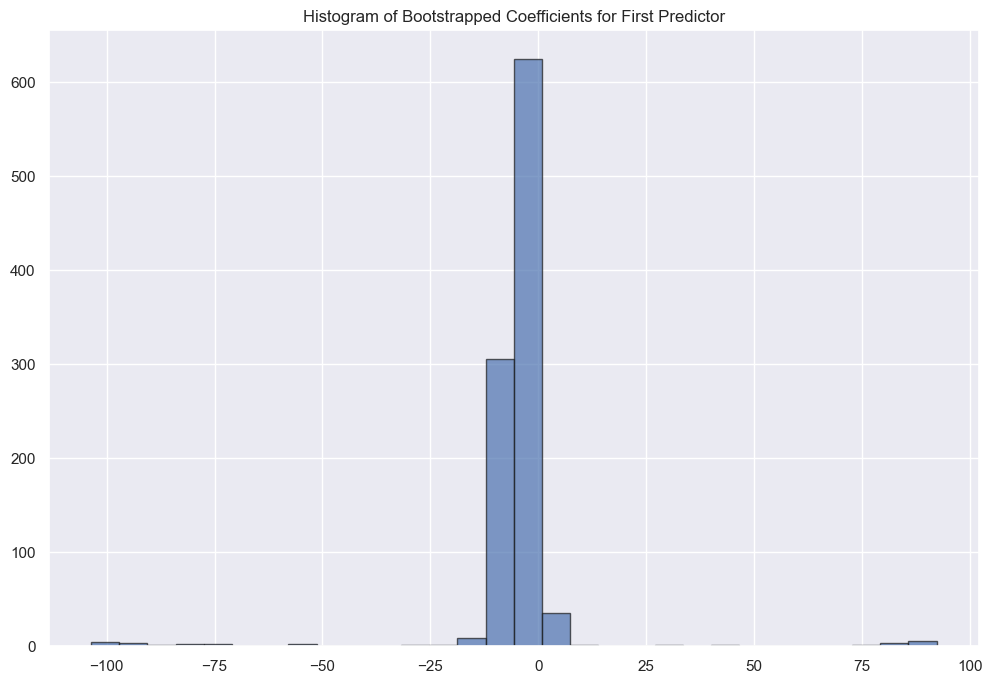

             const  ever_tbi_w_loc_clean    sex_clean  apo_e4_allele_clean  \
count  1000.000000           1000.000000  1000.000000          1000.000000   
mean     -4.797891             -0.537139     0.332246             1.561682   
std      13.493060             10.935049     0.897207             1.388307   
min    -103.630611           -126.352656    -3.156800            -3.496091   
25%      -6.377869             -0.517761    -0.200069             0.720115   
50%      -4.583468              1.076810     0.313247             1.606680   
75%      -2.930072              2.466379     0.855561             2.398373   
max      92.336454             65.321181     4.224562             7.604770   

             cerad  education_years_stages_bin  age_at_first_tbi_bin  \
count  1000.000000                 1000.000000           1000.000000   
mean      0.847552                   -0.424153              1.145260   
std       0.539958                    0.405699              5.186549   
min      

In [462]:
# Calculate summary statistics
summary_stats = bootstrapped_coeffs_df.describe()

# Compute 95% confidence intervals
confidence_intervals = bootstrapped_coeffs_df.quantile([0.025, 0.975])

# Example of plotting a histogram for the first coefficient
plt.hist(bootstrapped_coeffs_df.iloc[:, 0], bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of Bootstrapped Coefficients for First Predictor')
plt.show()

# Compare with original coefficients
original_coeffs = adjusted_results_with_weights.params
comparison = pd.DataFrame({'Original': original_coeffs, 'Mean Bootstrapped': summary_stats.loc['mean']})

print(summary_stats)
print(confidence_intervals)
print(comparison)


The bootstrapped coefficients and their statistics provide valuable insights into the stability and robustness of the model:

1. **Coefficient Variability**:
   - The standard deviations (`std`) are quite large for some coefficients, especially when compared to their means. This indicates a high degree of variability in the coefficient estimates across different samples. For example, `ever_tbi_w_loc_clean` and `age_at_first_tbi_bin` show particularly high variability.
   - The wide range between the minimum and maximum values for some coefficients further underscores this variability.


2. **Coefficient Mean vs. Original Model**:
   - Comparing the mean bootstrapped coefficients with the original coefficients, we observe some notable differences. For instance, the coefficient for `ever_tbi_w_loc_clean` has changed from a positive value in the original model to a negative mean value in the bootstrapped models.
   - These differences suggest that the original model's estimates might be sensitive to the specific sample of data used.


3. **Confidence Intervals**:
   - The 95% confidence intervals (from the 2.5th to the 97.5th percentiles) for some predictors are wide and sometimes include both positive and negative values (e.g., `ever_tbi_w_loc_clean`). This indicates uncertainty about the direction of the effect of these predictors.
   - Wide confidence intervals generally suggest a lack of precision in the estimation of the coefficients, which can be a sign of instability in the model.


4. **Overfitting Assessment**:
   - The high variability and wide confidence intervals in the bootstrapped coefficients suggest that the original model might be overfitting the data. Overfitting occurs when the model is too closely tailored to the specific nuances of the training data, reducing its ability to generalize to new data.


5. **Statistical Significance**:
   - Unlike the original GLM output, bootstrapping does not directly provide p-values for statistical significance testing. However, if the confidence intervals consistently exclude zero (especially for important predictors), it suggests that the effect of those predictors is statistically significant.
   - In this case, some predictors have confidence intervals that include zero, which means we cannot confidently assert their statistical significance based on this analysis alone.


## Watermark

In [463]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [464]:
%watermark

Last updated: 2023-12-09T01:57:56.037119+01:00

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.16.1

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 23.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit



In [465]:
%watermark --iversions

numpy      : 1.26.1
statsmodels: 0.14.0
pandas     : 2.1.1
matplotlib : 3.8.0
seaborn    : 0.13.0



-----


## Snapshot

In [466]:
today = date.today()
output_file = f"{ROOT_PATH}{PATH_HTML}{today}_{notebook_name}.html"
input_file = f"{notebook_name}.ipynb"
print(input_file)
!jupyter nbconvert --to html {input_file} --output {output_file}

03.02_causal_inference-modelling.ipynb
[NbConvertApp] Converting notebook 03.02_causal_inference-modelling.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 7 image(s).
[NbConvertApp] Writing 810408 bytes to ../reports/html/2023-12-09_03.02_causal_inference-modelling.html


In [467]:
# Construct the output file path
output_file = f"{ROOT_PATH}{PATH_HTML}{today}_{notebook_name}_no_code.html"

# Construct the input file path
input_file = f"{notebook_name}.ipynb"

# Convert the notebook to HTML without the code cells
os.system(f"jupyter nbconvert --to html {input_file} --output {output_file} --no-input")

[NbConvertApp] Converting notebook 03.02_causal_inference-modelling.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 7 image(s).
[NbConvertApp] Writing 714576 bytes to ../reports/html/2023-12-09_03.02_causal_inference-modelling_no_code.html


0